In [4]:
# for uploading files to s3
!pip install awscli-local[ver1]

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.9/3.9 MB 32.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 548.2/548.2 kB 36.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 44.7 MB/s eta 0:00:00:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.6/79.6 kB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.1/175.1 kB 24.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.5/132.5 kB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.1/77.1 kB 11.9 MB/s eta 0:00:00
  Created wheel for awscli-local: filename=awscli_local-0.20-py3-none-any.whl size=7002 sha256=7d83fd7cc3a040ee264bd39e9293eacf87f4fa2cc76c5d01a3406d250cbf47fa
  Stored in directory: /home/jovyan/.ca

In [5]:
import os
import s3fs
import json
import time
import random
import requests
import pprint

import numpy as np
import pandas as pd

from PIL import Image
from ipyplot import plot_images

### Helpers

Before to execute the 3 following lines (only on **Kubernetes**) , please upload images `10003.jpg`, `10000.jpg` and `10001.jpg` to `data` folder.

In [16]:
!awslocal s3 mb s3://fashion-datasets --endpoint-url=http://localstack:4566
!awslocal s3 mb s3://fashion-tasks --endpoint-url=http://localstack:4566
!awslocal s3 sync data s3://fashion-datasets/dataset-v1 --endpoint-url=http://localstack:4566

make_bucket: fashion-datasets
make_bucket: fashion-tasks
upload: data/10003.jpg to s3://fashion-datasets/dataset-v1/10003.jpg
upload: data/10000.jpg to s3://fashion-datasets/dataset-v1/10000.jpg
upload: data/10001.jpg to s3://fashion-datasets/dataset-v1/10001.jpg


In [7]:
# os.environ["API_HOST"] = "0.0.0.0"

In [17]:
S3_ENDPOINT = f'http://{os.getenv("S3_HOST")}:4566'
API_ENDPOINT = f'http://{os.getenv("API_HOST")}:5000'

In [18]:
# TMP
API_ENDPOINT
# TODO:
# - deploy FastAPI
# - run src/api/Dockerfile

'http://api:5000'

In [19]:
s3 = s3fs.S3FileSystem(client_kwargs={'endpoint_url': f'http://{os.getenv("S3_HOST")}:4566'})

In [20]:
performed_tasks = {}
def perform_task(params, endpoint):
    api_response = requests.post(f"{API_ENDPOINT}/{endpoint}", json=params).json()
    print(api_response)
    task_id = api_response['task_id']
    
    status = 'PENDING'
    print("Processing...")
    while status == 'PENDING':
        time.sleep(3)
        response = requests.get(f'{API_ENDPOINT}/task/{task_id}').json()
        print(response)
        status = response['status']
        
    performed_tasks[task_id] = {
        'params': params,
        'status': status,
        'result': response['result']
    }
        
    if status != 'SUCCESS':
        raise Exception(response)
    else:
        print("Task complete!")
        
    return response['result']['s3_target']

In [21]:
def draw_images(items, source_folder, sample=3):
    sample_items = random.sample(items, sample)
    
    images = []
    for item in sample_items:
        with s3.open(f'{source_folder}/{item["image_id"]}.jpg') as f:
            images.append(np.asarray(Image.open(f)))
    
    plot_images(images, labels=[item['image_id'] for item in sample_items], custom_texts=[pprint.pformat(item) for item in sample_items], zoom_scale=1.0)

## Sanity checks

In [22]:
# list(s3.walk("fashion-tasks"))

## Task 1:

Query for men's shoes based on date. 

{'task_id': '3d1e36d7-4946-44df-8ed5-c285fd8b065d'}
Processing...
{'id': '3d1e36d7-4946-44df-8ed5-c285fd8b065d', 'status': 'SUCCESS', 'error': None, 'result': {'s3_target': 's3://fashion-tasks/3d1e36d7-4946-44df-8ed5-c285fd8b065d'}}
Task complete!



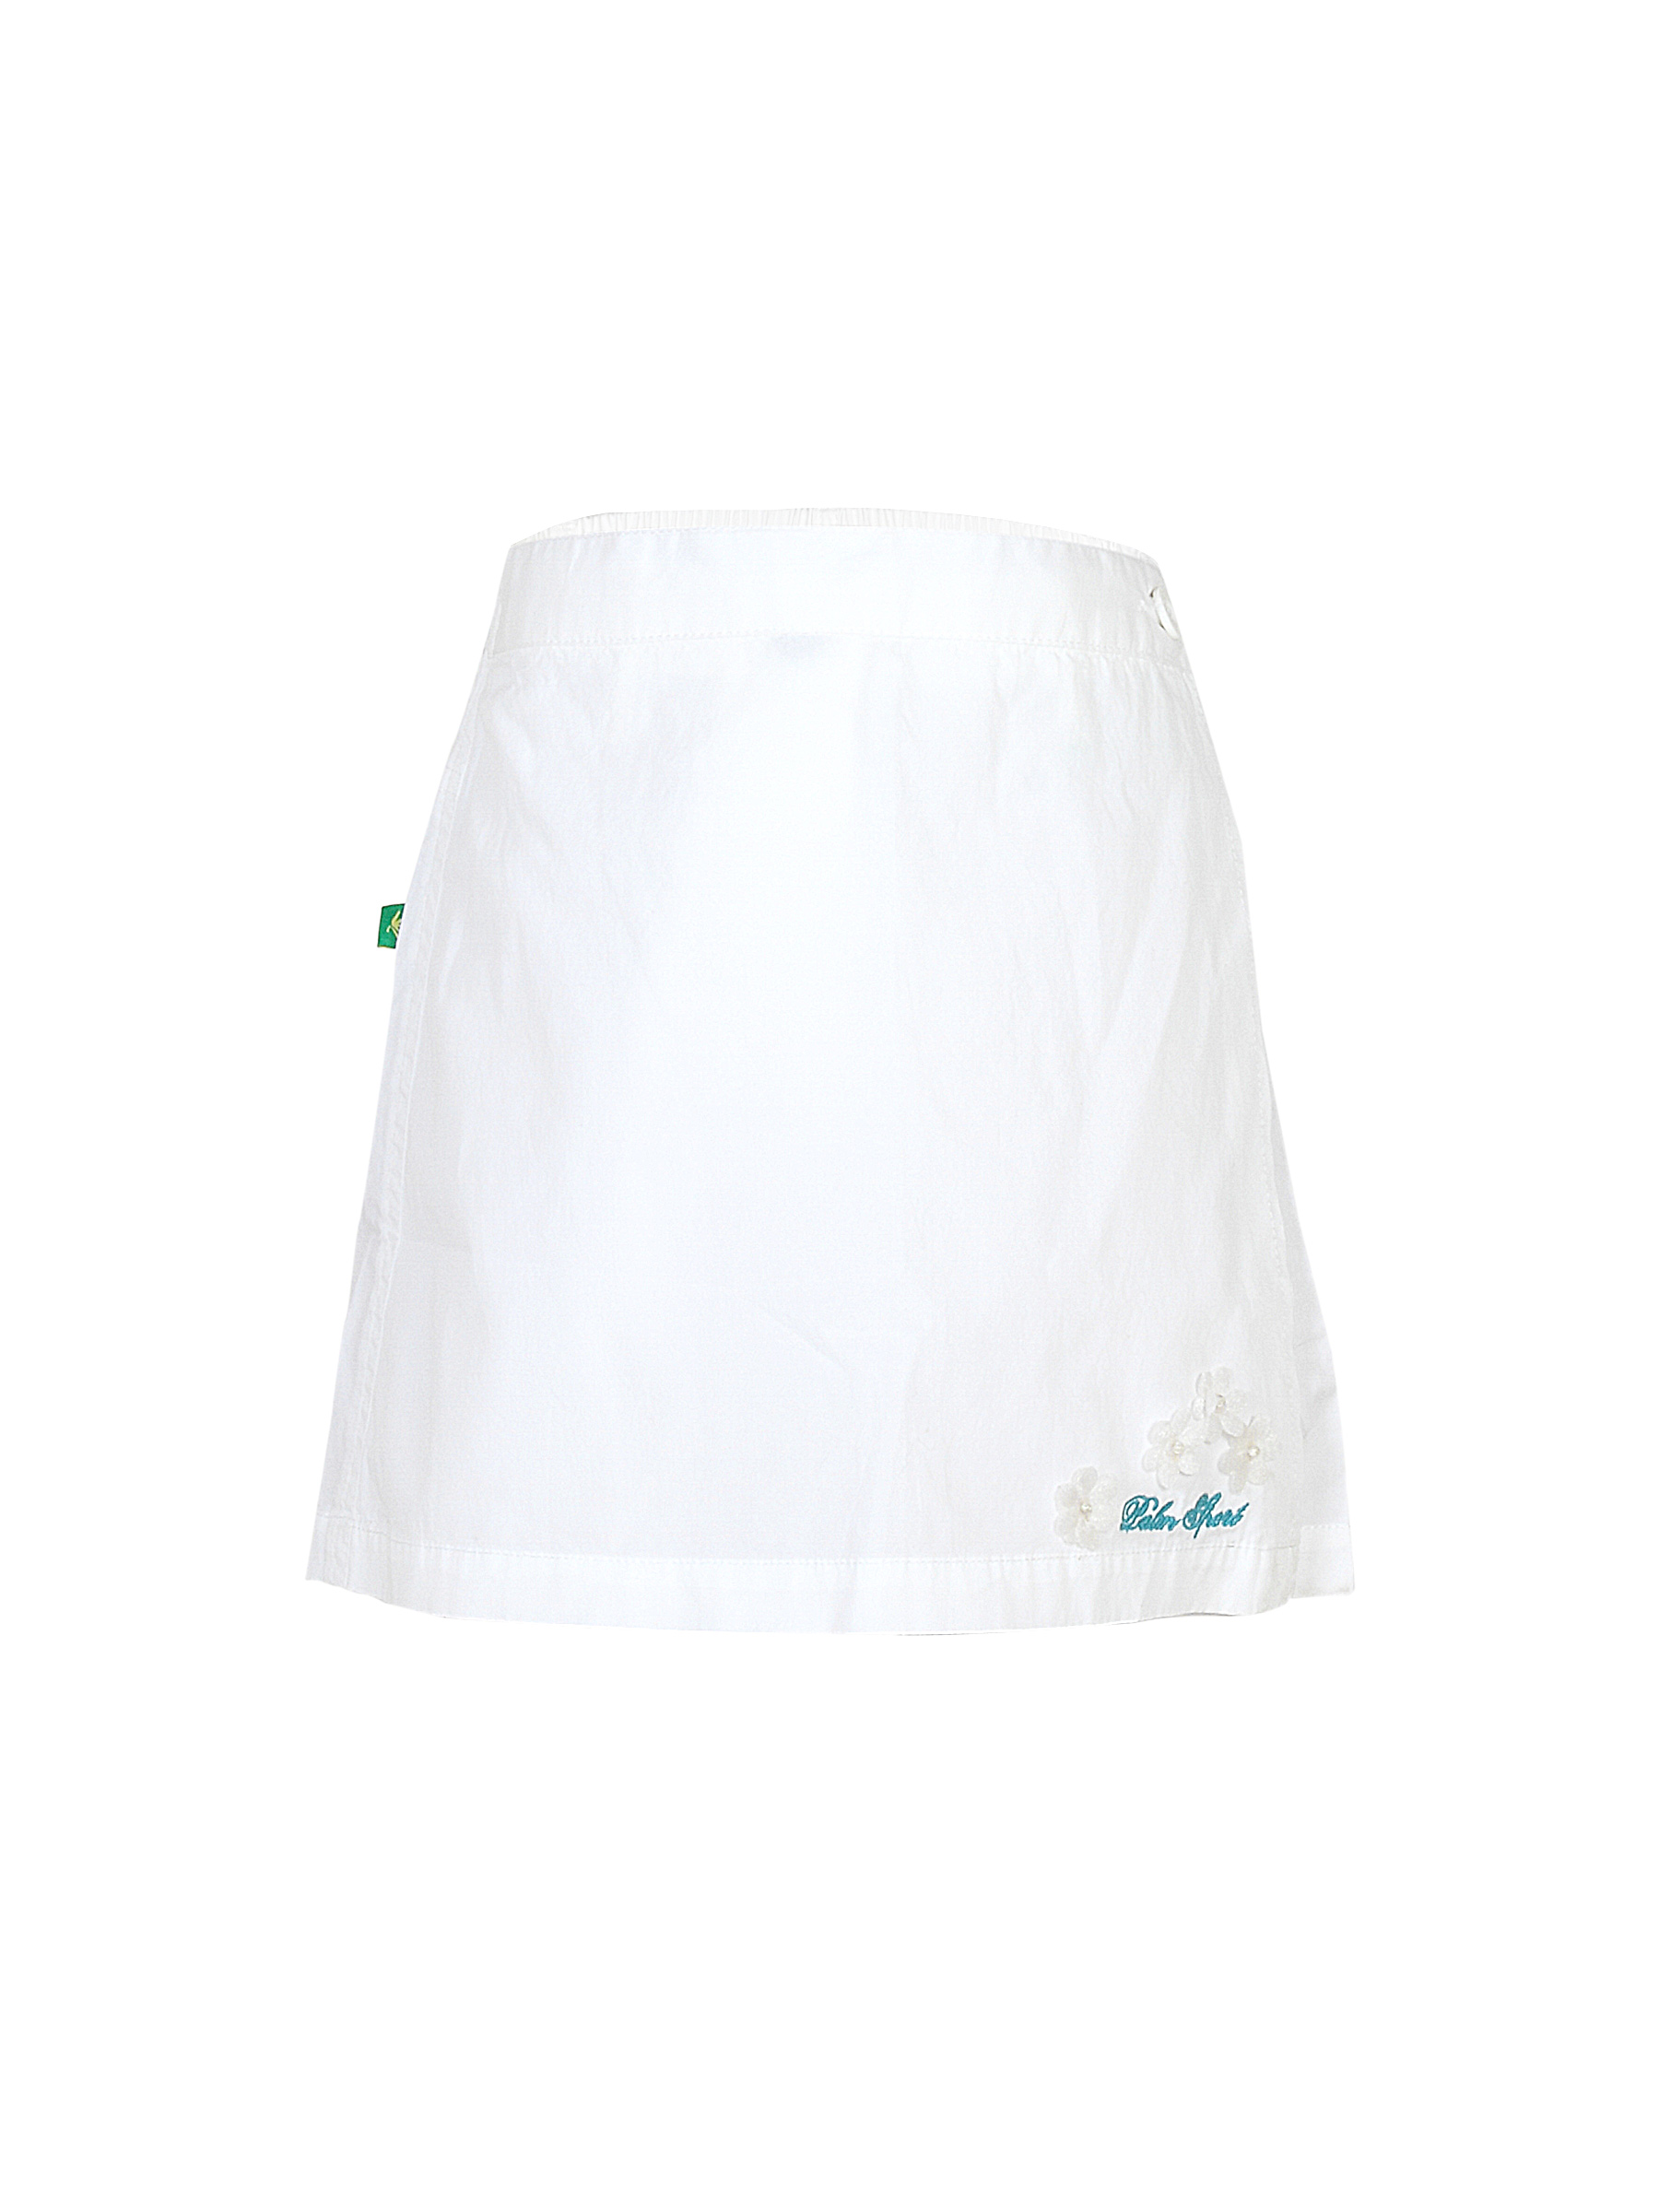


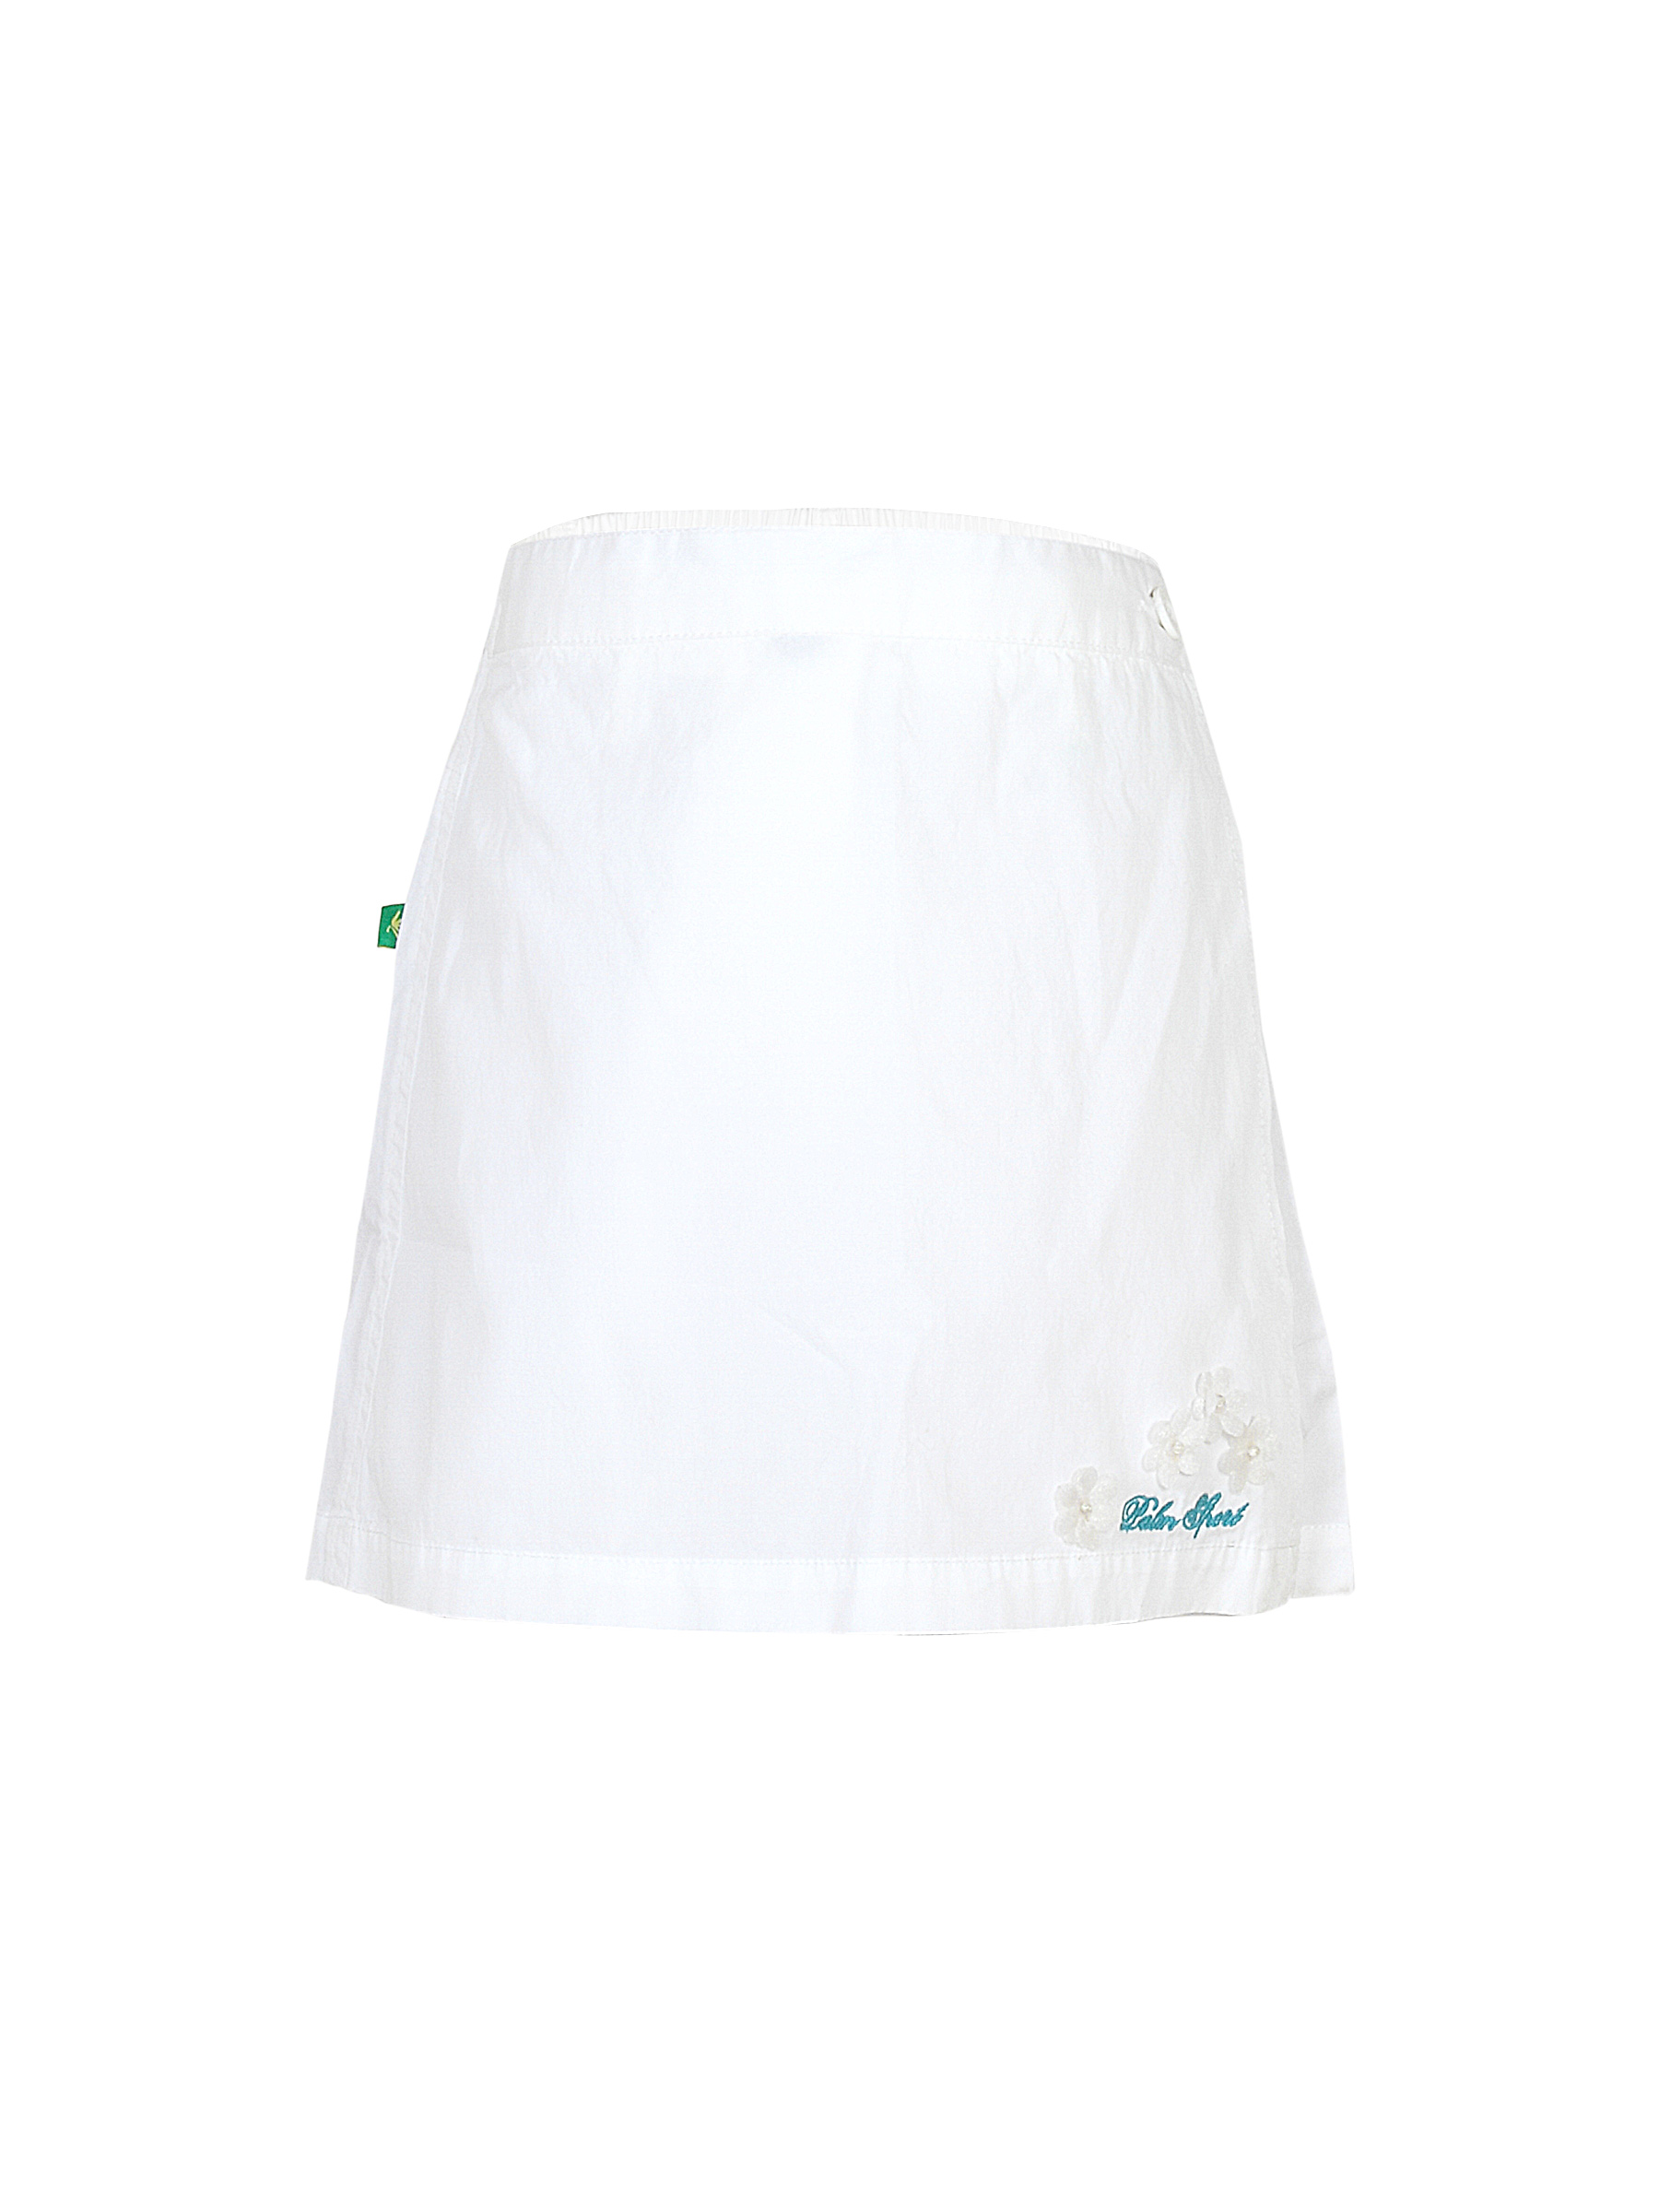

In [24]:
# LIMIT = 10
LIMIT = 1
# YEAR = 2012
YEAR = 2011

# payload = {
#     "gender": "Men", 
#     "sub_category": "Shoes", 
#     "start_year": YEAR,
#     "limit": LIMIT,
# }

payload = {
    "gender": "Women", 
    "sub_category": "Bottomwear", 
    "start_year": YEAR,
    "limit": LIMIT,
}

s3_target = perform_task(payload, "filter")

# filter results
with s3.open(f'{s3_target}/metadata.json') as f:
    metadata = json.load(f)

# sample of original images
draw_images(metadata, f'{s3_target}/images', sample=1)

## Task 2:

Run the same query, but now do augmentation to the images based on the given configuration

{'task_id': '96efd687-97bc-49c7-b3c9-a66d8ca008da'}
Processing...
{'id': '96efd687-97bc-49c7-b3c9-a66d8ca008da', 'status': 'SUCCESS', 'error': None, 'result': {'s3_target': 's3://fashion-tasks/96efd687-97bc-49c7-b3c9-a66d8ca008da'}}
Task complete!



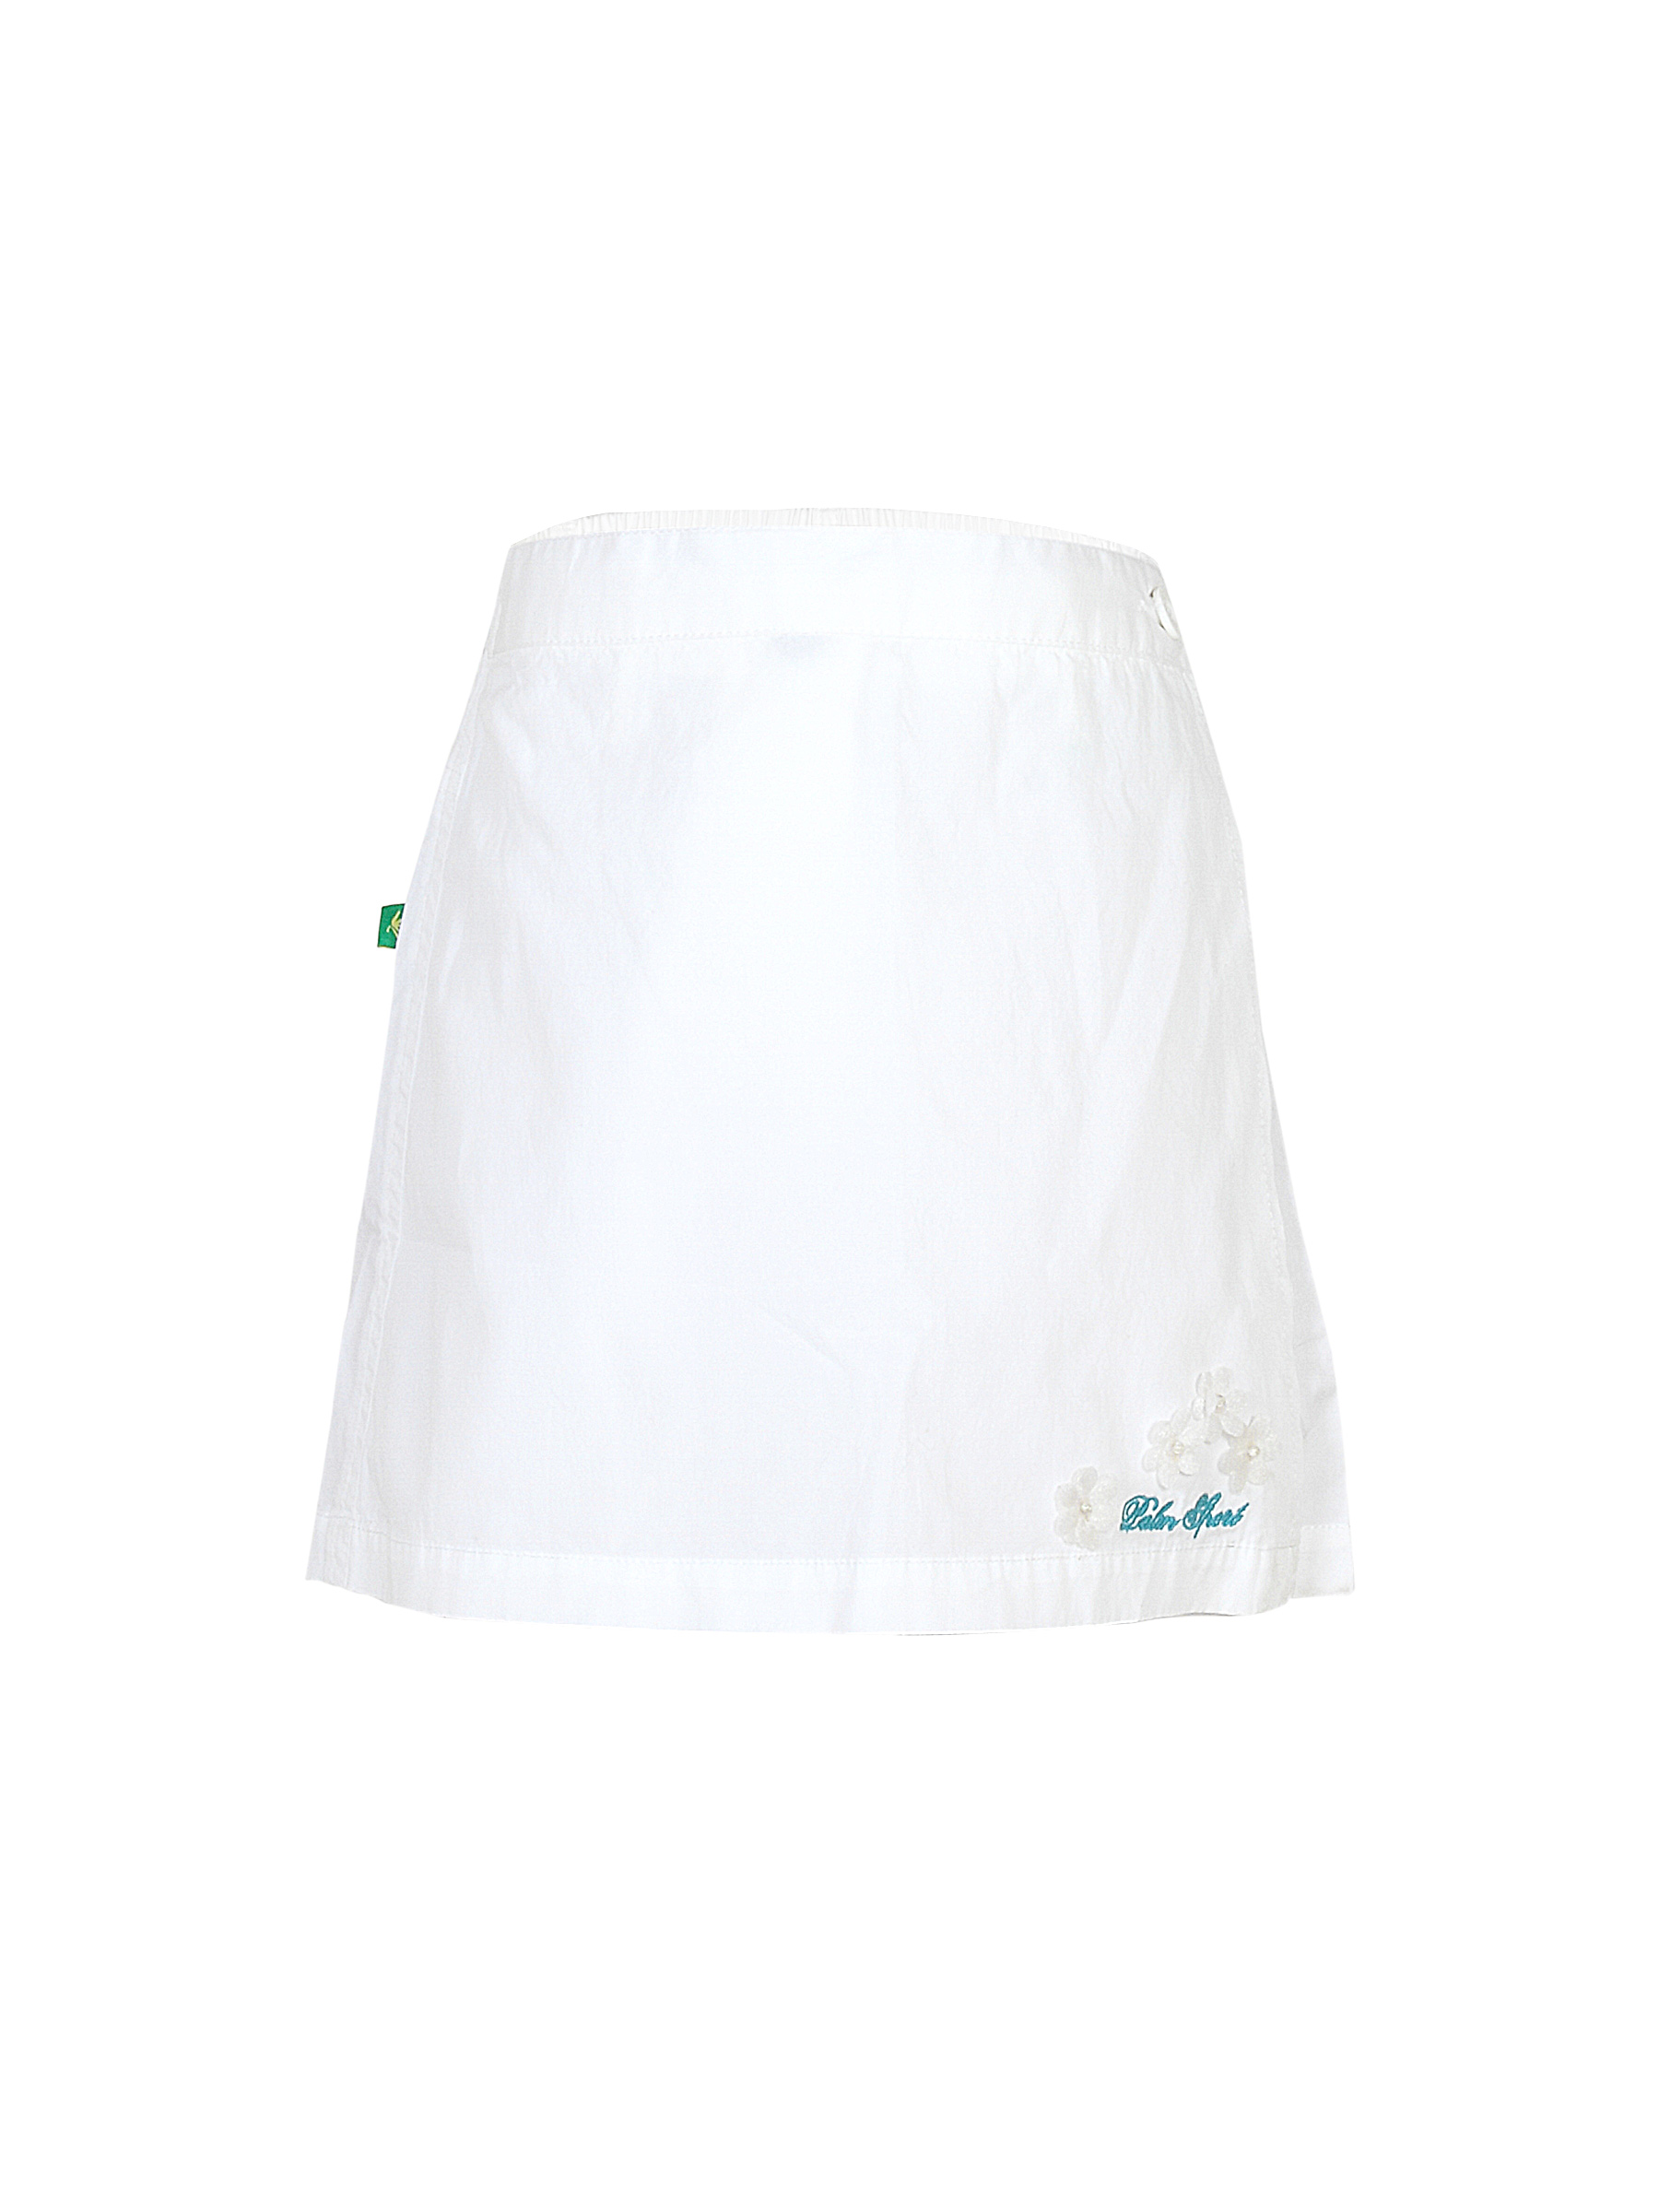


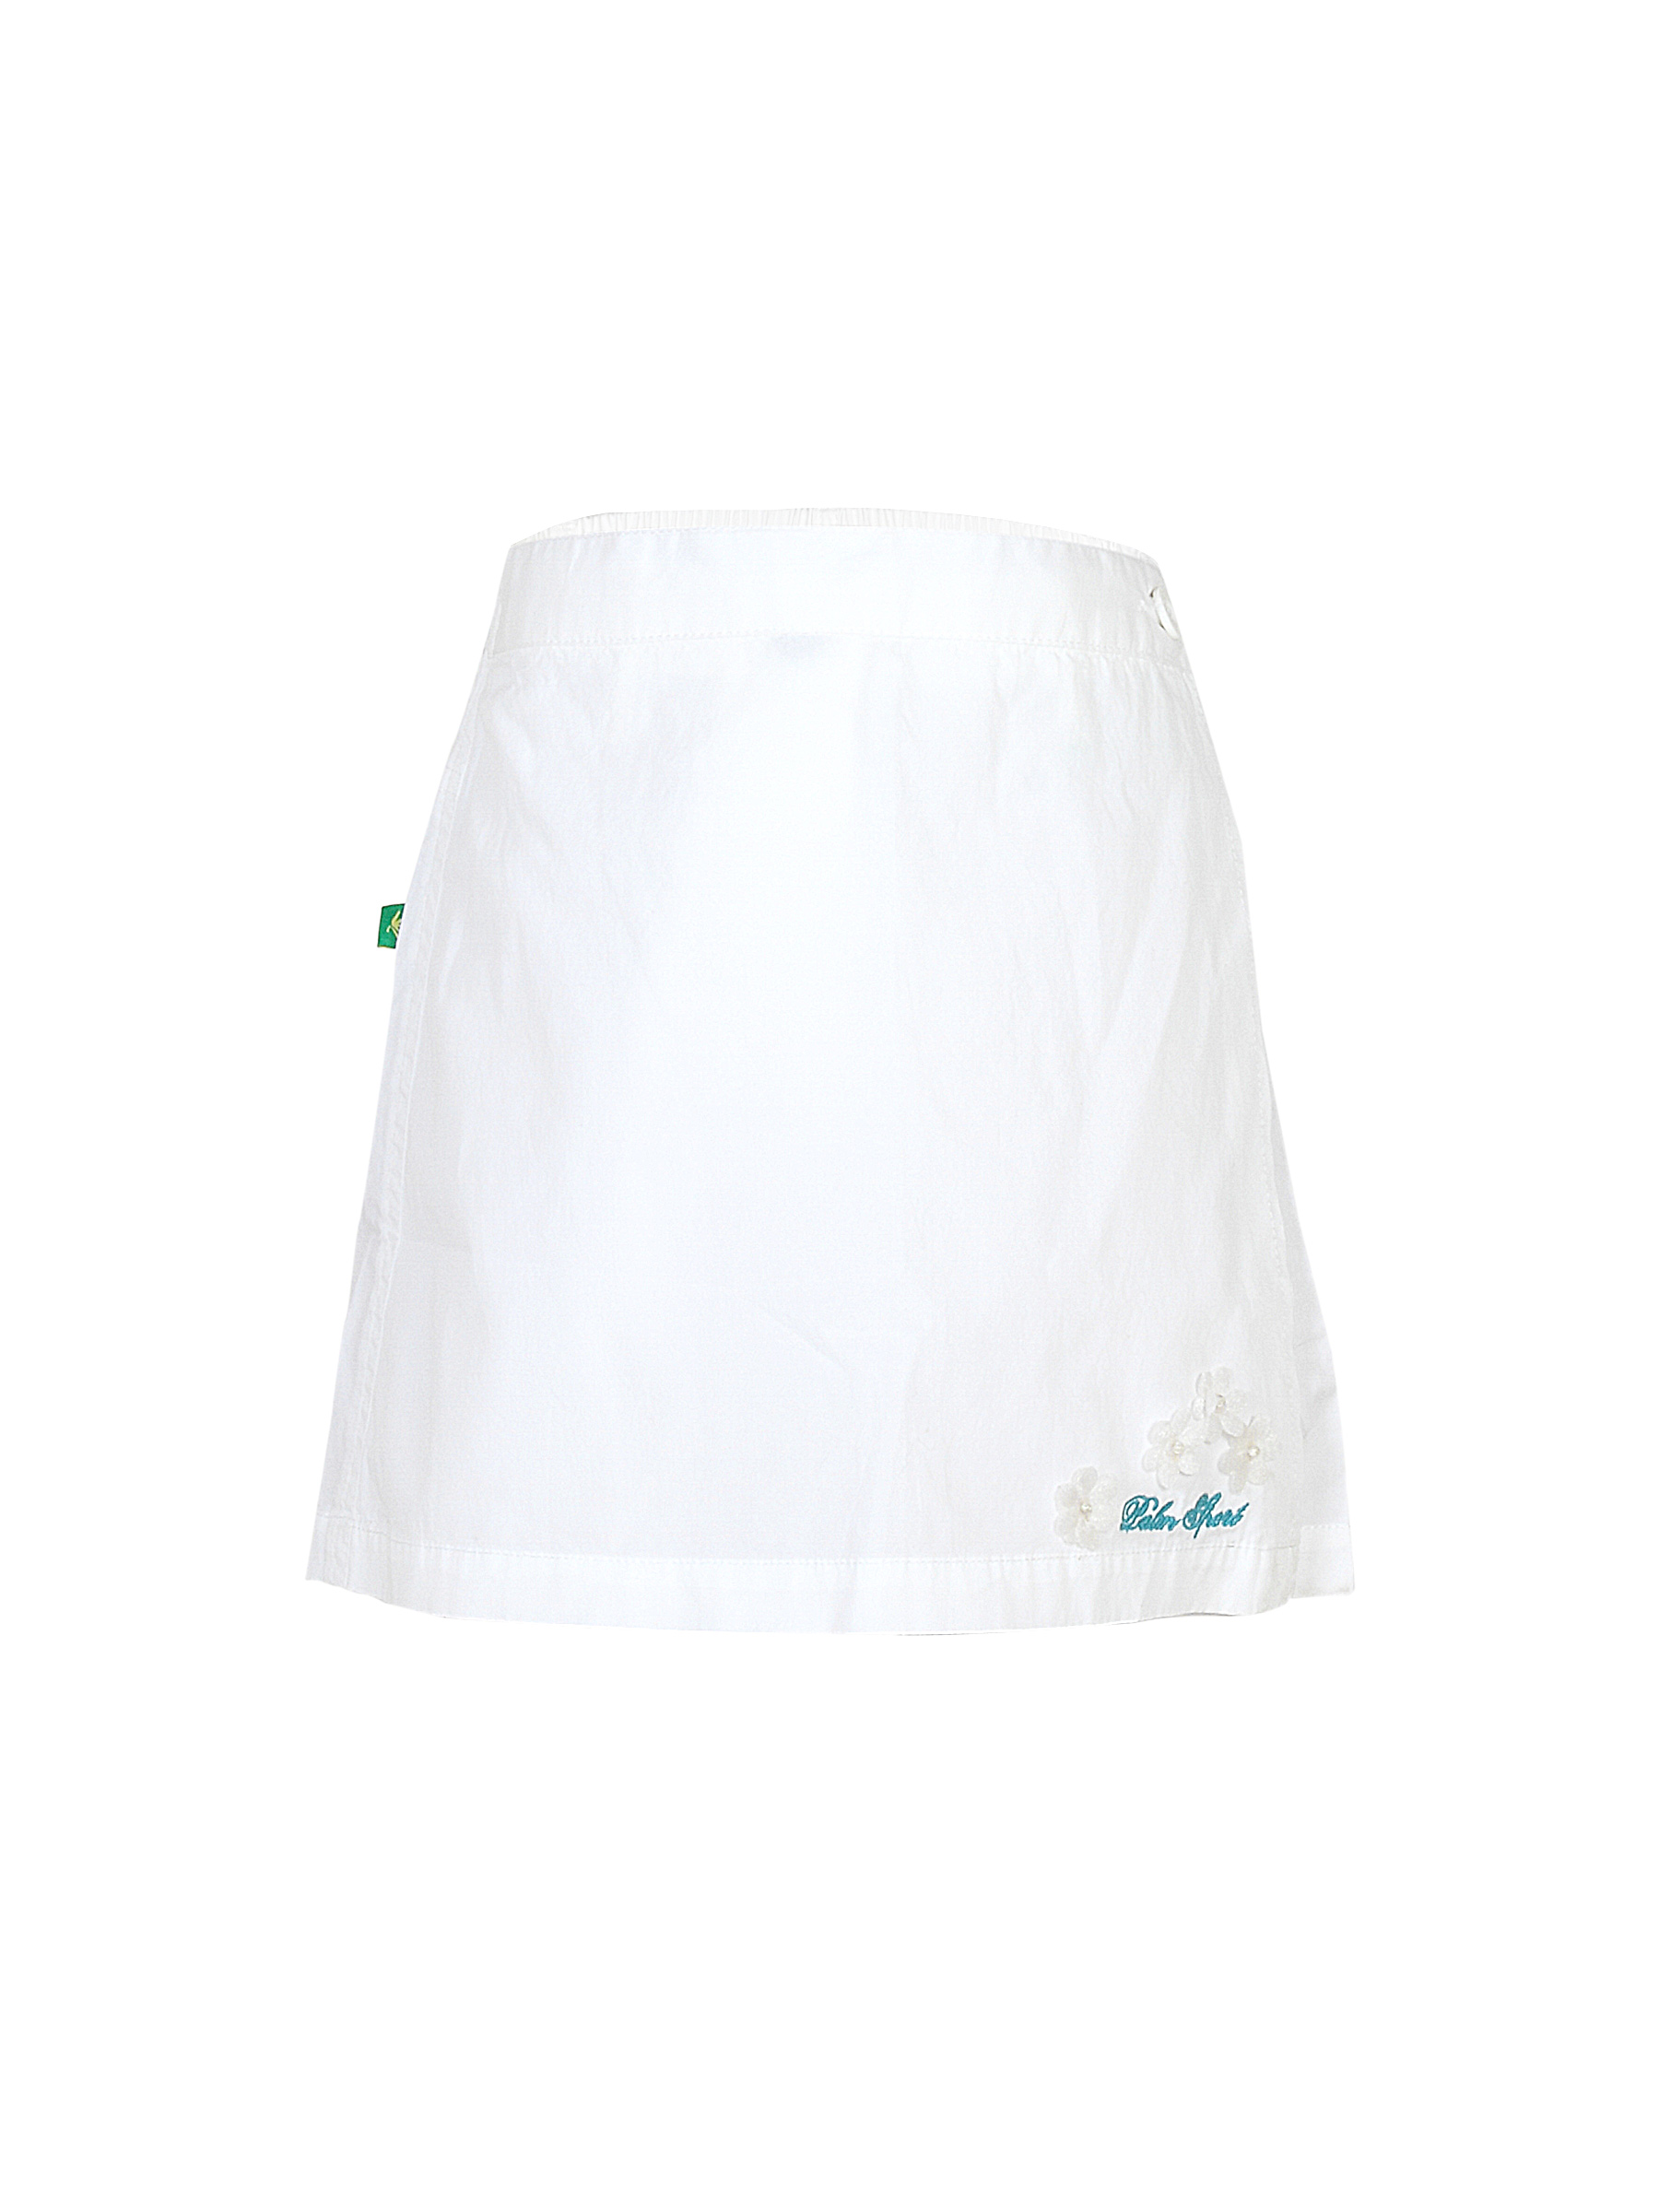


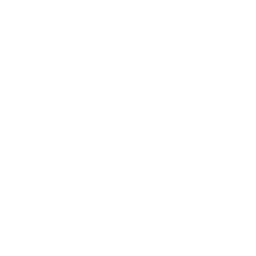


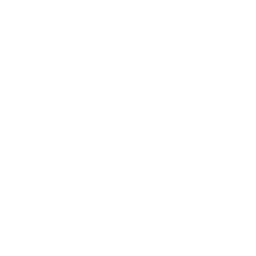

In [25]:
payload = {
    "gender": "Women", 
    "sub_category": "Bottomwear", 
    "start_year": YEAR,
    "limit": LIMIT,
    "augmentation_config": {'albumentation': {
        'input_image': {'width': 60, 'height': 80}, 
        'cropping': {'height': {'min': 10, 'max': 70}}, 
        'resize': {'width': 256, 'height': 256}}}
}

s3_target = perform_task(payload, "filter")

# filter results
with s3.open(f'{s3_target}/metadata.json') as f:
    metadata = json.load(f)

# sample of original images
draw_images(metadata, f'{s3_target}/images', sample=LIMIT)

# sample of transformed images
draw_images(metadata, f'{s3_target}/augmentation', sample=LIMIT)

## Task 3: 

Run inference using the FashionNetVgg16NoBn from https://github.com/i008/pytorch-deepfashion.git on the original images in Step 1 or 2.

In [26]:
s3_target = perform_task({"s3_target": s3_target}, "predict")

with s3.open(f'{s3_target}/predictions.json') as f:
    predictions = json.load(f)

print(f'Number of predictions: {len(predictions)}')
print(f'Prediction output per image: massive_attr-{len(predictions[0]["massive_attr"][0])}, categories-{len(predictions[0]["categories"][0])}')

{'task_id': '3cb1a437-ae8d-4fd1-ac13-e2b9417b2b9c'}
Processing...
{'id': '3cb1a437-ae8d-4fd1-ac13-e2b9417b2b9c', 'status': 'PENDING', 'error': None, 'result': None}
{'id': '3cb1a437-ae8d-4fd1-ac13-e2b9417b2b9c', 'status': 'PENDING', 'error': None, 'result': None}
{'id': '3cb1a437-ae8d-4fd1-ac13-e2b9417b2b9c', 'status': 'SUCCESS', 'error': None, 'result': {'s3_target': 's3://fashion-tasks/96efd687-97bc-49c7-b3c9-a66d8ca008da'}}
Task complete!
Number of predictions: 1
Prediction output per image: massive_attr-1000, categories-50
